## Лабораторная работа №1 по системам обработки больших данных

### Импортирование модулей

In [1]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

In [2]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *
from functools import reduce
from pyspark.sql import functions 
from pyspark.sql.types import *
from pyspark.sql.functions import length, mean, split, udf, col
from pyspark.sql import functions as F


MAX_MEMORY = '8G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Lab1") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()

filename_data = 'data/the-reddit-covid-dataset-comments.csv'
df = spark.read.csv(filename_data, mode="DROPMALFORMED")
print('Data frame type: ' + str(type(df)))

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


In [3]:
print('Data overview')
df.printSchema()
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Data overview
root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)

Columns overview


,Column Name,Data type
0,_c0,string
1,_c1,string
2,_c2,string
3,_c3,string
4,_c4,string
5,_c5,string
6,_c6,string
7,_c7,string
8,_c8,string
9,_c9,string


In [4]:
new_column_names = {
    "_c0": "type",
    "_c1": "id",
    "_c2": "subreddit_id",
    "_c3": "subreddit_name",
    "_c4": "subreddit_nsfw",
    "_c5": "created_utc",
    "_c6": "permalink",
    "_c7": "body",
    "_c8": "sentiment",
    "_c9": "score",
}

for c, new_c in new_column_names.items():
    df = df.withColumnRenamed(c, new_c)
 

df = df.withColumn("subreddit_nsfw", col("subreddit_nsfw").cast(BooleanType()))
df = df.withColumn("sentiment", col("sentiment").cast(FloatType()))
df = df.withColumn("score", col("score").cast(IntegerType()))

df = df.withColumn("word_count", size(split(col("body"), " ")).cast("int"))
df = df.withColumn("virus_count", size(split(col("body"), "virus")) - 1)
df = df.withColumn("covid_count", size(split(col("body"), "covid")) - 1)
df = df.withColumn("mood", F.when(df["sentiment"] >= 0, True).otherwise(False))

df = df.dropna()
df.printSchema()
df.show()

root
 |-- type: string (nullable = true)
 |-- id: string (nullable = true)
 |-- subreddit_id: string (nullable = true)
 |-- subreddit_name: string (nullable = true)
 |-- subreddit_nsfw: boolean (nullable = true)
 |-- created_utc: string (nullable = true)
 |-- permalink: string (nullable = true)
 |-- body: string (nullable = true)
 |-- sentiment: float (nullable = true)
 |-- score: integer (nullable = true)
 |-- word_count: integer (nullable = false)
 |-- virus_count: integer (nullable = false)
 |-- covid_count: integer (nullable = false)
 |-- mood: boolean (nullable = false)

+-------+-------+------------+--------------------+--------------+-----------+--------------------+--------------------+---------+-----+----------+-----------+-----------+-----+
|   type|     id|subreddit_id|      subreddit_name|subreddit_nsfw|created_utc|           permalink|                body|sentiment|score|word_count|virus_count|covid_count| mood|
+-------+-------+------------+--------------------+----------

In [5]:
num_col = ["score", "word_count"]
for col_name in num_col*2:
    quantiles = df.approxQuantile(col_name, [0.25, 0.75], 0.05)  # 25-й и 75-й процентили
    IQR = quantiles[1] - quantiles[0]
    lower_bound = quantiles[0] - 1.5 * IQR
    upper_bound = quantiles[1] + 1.5 * IQR
    df = df.filter((col(col_name) >= lower_bound) & (col(col_name) <= upper_bound))

<Axes: >

Text(0.5, 1.0, 'Boxplots of Numeric Columns')

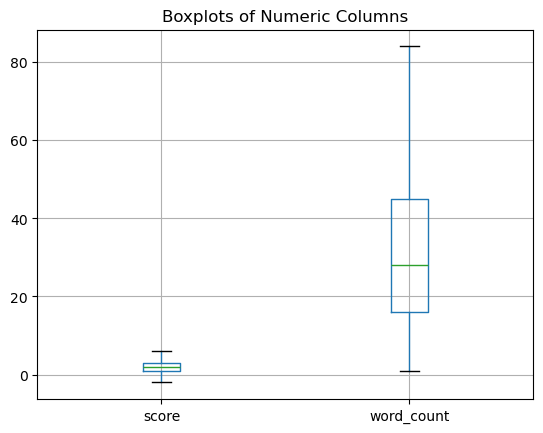

In [6]:
df_pandas = df.select(num_col).toPandas()
df_pandas.boxplot(column=num_col)
plt.title('Boxplots of Numeric Columns')
plt.show()

In [7]:
for col_name in num_col:
    quantiles = df.approxQuantile(col_name, [0.5], 0.05)
    median_score = quantiles[0]
    print(f'Median {col_name}: {median_score}\n')

df.select("score", "word_count").describe().show()

Median score: 1.0

Median word_count: 27.0

+-------+------------------+------------------+
|summary|             score|        word_count|
+-------+------------------+------------------+
|  count|           5543311|           5543311|
|   mean|1.9616886009101782|32.102521579611896|
| stddev|1.6147285433574878|19.803289526590607|
|    min|                -2|                 1|
|    max|                 6|                84|
+-------+------------------+------------------+



**count** - Количество строк\
**mean** - Среднее значение\
**stddev** - Стандартное отклонение\
**min** - Минимальное значение\
**max** - Максимальное значение

{'whiskers': [<matplotlib.lines.Line2D at 0x7f39e613be50>,
 'caps': [<matplotlib.lines.Line2D at 0x7f39ebbc1550>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f39e613b1d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f39ebbc2cd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f39ebbc3850>],
 'means': []}

Text(0.5, 1.0, 'Boxplot of score')

Text(0.5, 0, 'score')

Text(0, 0.5, 'Value')

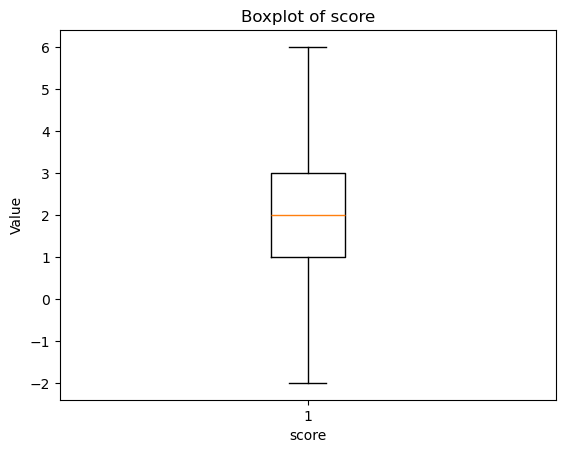

{'whiskers': [<matplotlib.lines.Line2D at 0x7f39d9bd7610>,
 'caps': [<matplotlib.lines.Line2D at 0x7f39d8aece10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f39d9bd6ad0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f39d8aee150>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f39d8aeec50>],
 'means': []}

Text(0.5, 1.0, 'Boxplot of word_count')

Text(0.5, 0, 'word_count')

Text(0, 0.5, 'Value')

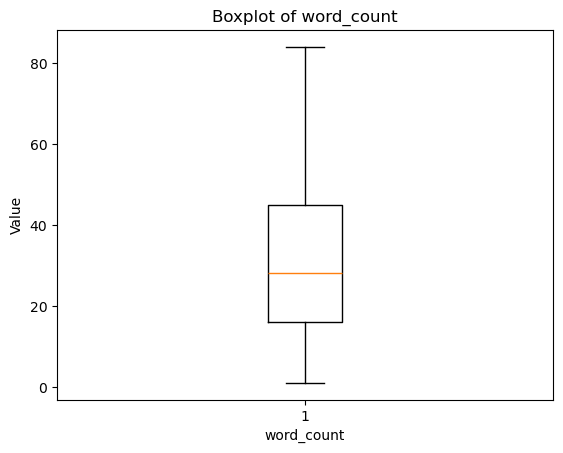

In [8]:
for col_name in num_col:
    data = df.select(col_name).rdd.flatMap(lambda x: x).collect()
    plt.boxplot(data)
    plt.title(f'Boxplot of {col_name}')
    plt.xlabel(col_name)
    plt.ylabel('Value')
    plt.show()

<Axes: >

([<matplotlib.patches.Wedge at 0x7f39f8152310>,
 [Text(1.099610922223856, 0.029254396695218815, 'True'),
  Text(-1.0996109224806367, -0.029254387043374484, 'False')],
 [Text(0.5997877757584668, 0.015956943651937533, '0.8%'),
  Text(-0.599787775898529, -0.015956938387295172, '99.2%')])

Text(0.5, 1.0, 'NSFW Percentage')

<Axes: >

([<matplotlib.patches.Wedge at 0x7f39d582d310>,
 [Text(-0.35943513484708367, 1.0396183837531245, 'True'),
  Text(0.3594351348470838, -1.0396183837531245, 'False')],
 [Text(-0.19605552809840926, 0.5670645729562497, '60.6%'),
  Text(0.19605552809840932, -0.5670645729562497, '39.4%')])

Text(0.5, 1.0, 'Mood Percentage')

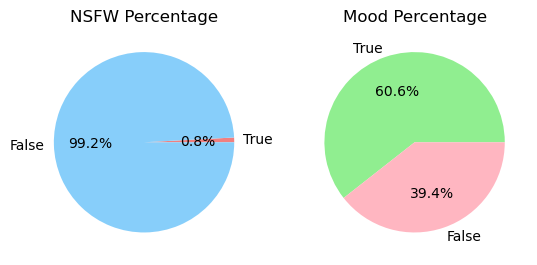

In [9]:
count_values_nsfw = df.groupBy("subreddit_nsfw").count().collect()
count_values_mood = df.groupBy("mood").count().collect()

values_nsfw = [x['count'] for x in count_values_nsfw]
categories_nsfw = [str(x['subreddit_nsfw']) for x in count_values_nsfw]

values_mood = [x['count'] for x in count_values_mood]
categories_mood = [str(x['mood']) for x in count_values_mood]

plt.subplot(121)
plt.pie(values_nsfw, labels=categories_nsfw, autopct='%1.1f%%', colors=['lightcoral', 'lightskyblue'])
plt.title('NSFW Percentage')

plt.subplot(122)
plt.pie(values_mood, labels=categories_mood, autopct='%1.1f%%', colors=['lightgreen', 'lightpink'])
plt.title('Mood Percentage')

plt.show()

In [13]:
count_nsfw_posts = df.filter(df["subreddit_nsfw"] == True).count()
print(f'Количество постов с NSFW: {count_nsfw_posts}\n')
count_mood_posts = df.filter(df["mood"] == True).count()
print(f'Количество постов с положительным или нейтральным настроением: {count_mood_posts}\n')

Количество постов с NSFW: 46932

Количество постов с положительным или нейтральным настроением: 3359006



In [11]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
selected_data = df.select("score", "sentiment", "word_count", "virus_count", "covid_count")

assembler = VectorAssembler(inputCols=["score", "sentiment", "word_count", "virus_count", "covid_count"], outputCol="features")
assembled_data = assembler.transform(selected_data)
correlation_matrix = Correlation.corr(assembled_data, "features").head()
corr_matrix = correlation_matrix[0].toArray()
correlation_df = spark.createDataFrame(corr_matrix, ["score", "sentiment", "word_count", "virus_count", "covid_count"])
correlation_df.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+
|               score|           sentiment|          word_count|         virus_count|         covid_count|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|                 1.0|0.011157851932508638|0.029599152241561275|-0.00597646107447...|-0.02551334765691...|
|0.011157851932508638|                 1.0| 0.04656137014592415|-0.02786188446148...|-0.01561650193858...|
|0.029599152241561275| 0.04656137014592415|                 1.0| 0.08417894734600344| 0.03202809058384242|
|-0.00597646107447...|-0.02786188446148...| 0.08417894734600344|                 1.0| 0.01093154719763804|
|-0.02551334765691...|-0.01561650193858...| 0.03202809058384242| 0.01093154719763804|                 1.0|
+--------------------+--------------------+--------------------+--------------------+--------------------+



In [12]:
df.count()

5543311

In [ ]:
df.write.mode('overwrite').parquet("data/df.parquet")